# A5.1 Reinforcement Learning for Marble with Variable Goal

For this assignment, start with the `19 Reinforcement Learning Modular Framework` notebook.  Recall that this code used reinforcement learning to learn to push a marble towards the goal position of 5 and keep it there.

The objective of the following required modification is an agent that has been trained to directly move the marble to a specified goal without any further training. 

<font color="red">Modify the code</font> to allow any goal position from 1 to 9.  First, rename the `Marble` class to `Marble_Variable_Goal`.  Then, modify the `Marble_Variable_Goal` class so that it includes the goal in the state, allowing the agent to learn to push the marble to any given goal.  Modify the `intial_state` function to set the goal to a random integer from 1 to 9.

<font color='red'>Do not modify</font> the `Qnet` class. It should run correctly when applied to your new `Marble_Variable_Goal` class.

<font color='red'>Discuss</font> what you modified in the code for this assignment.

<font color='red'>Add some code</font> at the end of the notebook that applies the trained agent to the marble at goals from 1 to 9.  For each goal, start the marble at positions 0 through 10 with zero velocity and the specified goal and applies the trained agent to control the marble for 200 steps.  Calculate the distance of the final state from the goal.  Average this distance over all starting positions for the specified goal and store in a numpy array with one row for each goal and each row containing the goal and the average of distances to goal over all starting positions. Call this numpy array, `distances_to_goal`.  Plot the results of these average distances versus the goal.

<font color='red'>Explore different parameter values</font>, including the network hidden layer structure, number of trials, number of steps per trial, learning rate, number of epochs, and final epsilon value to try to get the best results for `distances_to_goal`. Try just three or four different values for each parameter, varying one parameter value at a time. After you have found some parameter values that often work well, set the parameters to these values and run again to produce the graphs from `plot_status` showing the results with these parameters. But, first <font color='red'>modify `plot_status` code</font> for subplots 6 and 9 so that the vertical pink goal region correctly shows the current goal.  Add the current goal to the title of the subplot 9.

<font color='red'>Discuss</font> the results, and discuss which parameter values seem to perform well.

Here is some code and parameter values that I have found to be successful...usually.  As you know, results vary quite a bit from one run to another. Understand that you will not find parameter values that work perfectly every time.  You are welcome to start with these parameter values and experiment with variations of these.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import neuralnetworks_A4 as nn   # from A4
import random

from IPython.display import display, clear_output

In [2]:
from abc import ABC, abstractmethod
    
class Environment(ABC):
    
    def __init__(self, valid_actions):
        self.valid_actions = valid_actions

    @abstractmethod
    def initial_state(self):
        return state  # the initial state
    
    @abstractmethod
    def next_state(self, state, action):
        return next_state  
    
    @abstractmethod
    def reinforcement(self, state):
        return r # scalar reinforcement
   
    def terminal_state(self, state):
        return False  # True if state is terminal state

In [3]:
class Marble(Environment):

    def __init__(self, valid_actions):
        super().__init__(valid_actions)
        
    def initial_state(self):
        return np.array([10 * np.random.uniform(), 0.0]) ##initial random position 
                                        #and initial velocity = 0  and desired goal position of the marble in a array
        
    def next_state(self, state, action):
        '''[0] is position, s[1] is velocity. a is -1, 0 or 1'''    
        next_state = state.copy()
        deltaT = 0.1                           # Euler integration time step
        next_state[0] += deltaT * state[1]                  # Update position
        force = action
        mass = 0.5
        next_state[1] += deltaT * (force / mass - 0.2 * state[1])  # Update velocity. Includes friction

        # Bound next position. If at limits, set velocity to 0.
        if next_state[0] < 0:        
            next_state = [0., 0.]    # these constants as ints were causing the errors we discussed in class. I DON'T KNOW WHY!!
        elif next_state[0] > 10:
            next_state = [10., 0.]

        return next_state

    def reinforcement(self, state):
        goal = 5 # third element of the state array is the randomly generated desired goal value
        return 0 if abs(state[0]- goal) < 1 else -1

    def terminal_state(self, state):
        return False

In [4]:
class Marble_Variable_Goal(Environment):

    def __init__(self, valid_actions):
        super().__init__(valid_actions)
        
    def initial_state(self):
        global var_goal
        var_goal = random.randint(1,9)
        #print(var_goal)
        return np.array([10 * np.random.uniform(), 0.0,var_goal]) ##initial random position 
                                        #and initial velocity = 0  and desired goal position of the marble in a array
        
    def next_state(self, state, action):
        '''[0] is position, s[1] is velocity. a is -1, 0 or 1'''    
        next_state = state.copy()
        deltaT = 0.1                       # Euler integration time step
        next_state[0] += deltaT * state[1]                  # Update position
        force = action
        mass = 0.5
        next_state[1] += deltaT * (force / mass - 0.2 * state[1])  # Update velocity. Includes friction

        # Bound next position. If at limits, set velocity to 0.
        if next_state[0] < 0:        
            next_state = [0., 0., next_state[2]]    # these constants as ints were causing the errors we discussed in class. I DON'T KNOW WHY!!
        elif next_state[0] > 10:
            next_state = [10., 0., next_state[2]]

        return next_state

    def reinforcement(self, state):
        goal = state[2] # third element of the state array is the randomly generated desired goal value
        return 0 if abs(state[0] - goal) < 1 else -1

    def terminal_state(self, state):
        return False

In [5]:
class Agent(ABC):
    
    def __init__(self, environment):
        self.environment = environment

    @abstractmethod
    def make_samples(self, n_samples, epsilon):
        return X, R, Qn, terminal_state

    def update_Qn(self, X, Qn, terminal_state):
        n_samples = X.shape[0]
        for i in range(n_samples - 1):
            if not terminal_state[i+1]:
                Qn[i] = self.use(X[i+1])
        return Qn

    def epsilon_greedy(self, state, epsilon):
        valid_actions = self.environment.valid_actions

        if np.random.uniform() < epsilon:
            # Random Move
            action = np.random.choice(valid_actions)
        else:
            # Greedy Move
            Qs = [self.use(np.hstack((state, a)).reshape((1, -1))) for a in valid_actions]
            ai = np.argmax(Qs)
            action = valid_actions[ai]

        return action

    @abstractmethod
    def train(self):
        return

    @abstractmethod
    def use(self, X):
        return # Q values for each row of X, each consisting of state and action

In [6]:
class Qnet(Agent):

    def __init__(self, environment, hidden_layers, X_means=None, X_stds=None, Q_means=None, Q_stds=None):
        self.environment = environment
        state_size = environment.initial_state().size  # assumes state is an np.array
        valid_actions = environment.valid_actions
        action_size = 1 if valid_actions.ndim == 1 else valid_actions.shape[1]

        self.Qnet = nn.NeuralNetwork(state_size + action_size, hidden_layers, 1)
        if X_means:
            self.Qnet.X_means = np.array(X_means)
            self.Qnet.X_stds = np.array(X_stds)
            self.Qnet.T_means = np.array(Q_means)
            self.Qnet.T_stds = np.array(Q_stds)

    def make_samples(self, n_samples, epsilon):
 
        state_size = self.environment.initial_state().size # assumes state is an np.array
        valid_actions = self.environment.valid_actions
        action_size = 1 if valid_actions.ndim == 1 else valid_actions.shape[1]

        X = np.zeros((n_samples, state_size + action_size))
        R = np.zeros((n_samples, 1))
        Qn = np.zeros((n_samples, 1))
        terminal_state = np.zeros((n_samples, 1), dtype=bool)  # All False values

        state = self.environment.initial_state()
        state = self.environment.next_state(state, 0)        # Update state, sn from s and a
        action = self.epsilon_greedy(state, epsilon)

        # Collect data from n_samples steps
        for step in range(n_samples):

            next_state = self.environment.next_state(state, action)        # Update state, sn from s and a
            r = self.environment.reinforcement(state)   # Calculate resulting reinforcement
            next_action = self.epsilon_greedy(next_state, epsilon)
            X[step, :] = np.hstack((state, action))
            R[step, 0] = r
            if self.environment.terminal_state(state):
                terminal_state[step, 0] = True
                Qn[step, 0] = 0
            else:
                Qn[step, 0] = self.use(np.hstack((next_state, next_action)))
            # Advance one time step
            state, action = next_state, next_action

        return X, R, Qn, terminal_state

    #def update_Qn(self, X, Qn, terminal_state): ## defined twice can be removed
        #n_samples = X.shape[0]
        #for i in range(n_samples - 1):
         #   if not terminal_state[i+1]:
         #       Qn[i] = self.use(X[i+1])
        #return Qn

    def train(self, n_trials, n_steps_per_trial, n_epochs, method, learning_rate, 
              gamma, epsilon, final_epsilon,
              trial_callback=None):

        if trial_callback:
            fig = plt.figure(figsize=(10, 10))
            
        epsilon_decay =  np.exp(np.log(final_epsilon) / n_trials) # to produce this final value
        print('epsilon_decay is', epsilon_decay)
        epsilon_trace = np.zeros(n_trials)
        r_trace = np.zeros(n_trials)

        for trial in range(n_trials):

            X, R, Qn, terminal_state = self.make_samples(n_steps_per_trial, epsilon)

            for epoch in range(n_epochs):
                self.Qnet.train(X, R + gamma * Qn, 1,  method=method, learning_rate=learning_rate, batch_size=None, verbose=False)
                self.update_Qn(X, Qn, terminal_state)

            epsilon *= epsilon_decay

            # Rest is for plotting
            epsilon_trace[trial] = epsilon
            r_trace[trial] = np.mean(R)

            if trial_callback and (trial + 1 == n_trials or trial % (n_trials / 50) == 0):
                fig.clf()
                trial_callback(agent, trial, n_trials, X, epsilon_trace, r_trace)
                clear_output(wait=True)
                display(fig)

        if trial_callback:
            clear_output(wait=True)

        return epsilon_trace, r_trace

    def use(self, X):
        return self.Qnet.use(X)

In [7]:
from matplotlib import cm

def plot_status(agent, trial, n_trials, X, epsilon_trace, r_trace):
    

    plt.subplot(3, 3, 1)
    plt.plot(epsilon_trace[:trial + 1])
    plt.ylabel('Random Action Probability ($\epsilon$)')
    plt.ylim(0, 1)
               
    plt.subplot(3, 3, 2)
    plt.plot(r_trace[:trial + 1], alpha=0.5)
    plt.ylabel('Mean reinforcement')
        
    valid_actions = agent.environment.valid_actions
    #print(np.array([[s, 0, var_goal, a] for a in valid_actions for s in range(11)]))
    #qs = agent.use(np.array([[s, 0, X[0,2], s, X[0,5], 0, a] for a in valid_actions for s in range(11)]))
    ##Above line for 2D and below line for 1D
    qs = agent.use(np.array([[s, 0, X[0,2], a] for a in valid_actions for s in range(11)]))
               
    plt.subplot(3, 3, 3)
    acts = ['L', '0', 'R']
    actsiByState = np.argmax(qs.reshape((len(valid_actions), -1)), axis=0)
    for i in range(11):
        plt.text(i, 0, acts[actsiByState[i]])
        plt.xlim(-1, 11)
        plt.ylim(-1, 1)
    plt.text(2, 0.2,'Policy for Zero Velocity')
    plt.axis('off')
               
       
    plt.subplot(3, 3, 4)
    n = 20
    positions = np.linspace(0, 10, n)
    velocities =  np.linspace(-5, 5, n)
    xs, ys = np.meshgrid(positions, velocities)
    xsflat = xs.flat
    ysflat = ys.flat
    qs = agent.use(np.array([[xsflat[i], ysflat[i], X[0,2], a] for a in valid_actions for i in range(len(xsflat))]))     
    #qs = agent.use(np.array([[xsflat[i], ysflat[i], X[0,2],X[0,5] a] for a in valid_actions for i in range(len(xsflat))]))
    qs = qs.reshape((len(valid_actions), -1)).T
    qsmax = np.max(qs, axis=1).reshape(xs.shape)
    cs = plt.contourf(xs, ys, qsmax, 20, cmap=cm.coolwarm)
    plt.colorbar(cs)
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.title('Max Q')

               
    plt.subplot(3, 3, 5)
    acts = np.array(valid_actions)[np.argmax(qs, axis=1)].reshape(xs.shape)
    cs = plt.contourf(xs, ys, acts, [-2, -0.5, 0.5, 2], cmap=cm.coolwarm)
    plt.colorbar(cs)
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.title('Actions')

    plt.subplot(3, 3, 6)
    plt.plot(X[:, 0], X[: ,1])
    plt.plot(X[-1, 0], X[-1, 1], 'ro')
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.fill_between([X[0,2]-1 , X[0,2]+1], [-5, -5], [5, 5], color='red', alpha=0.3)  # CHECK OUT THIS FUNCTION!
    plt.xlim(-1, 11)
    plt.ylim(-5, 5)
    plt.title('Last Trial and goal='+ str(X[0,2]))

    ax = plt.subplot(3, 3, 7, projection='3d')
    ax.plot_surface(xs, ys, qsmax, linewidth=0, cmap=cm.coolwarm)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\dot{x}$')
    plt.title('Max Q')

    ax = plt.subplot(3, 3, 8, projection='3d')
    ax.plot_surface(xs, ys, acts, cmap=cm.coolwarm, linewidth=0)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\dot{x}$')
    plt.title('Action')
    
    test_it(agent, 10, 500)

    plt.tight_layout()

def test_it(agent, n_trials, n_steps_per_trial):
    #for gl in range(10):
    #test_goal = random.randint(1,9)
    xs = np.linspace(0, 10, n_trials)
    test_goal = var_goal
    plt.subplot(3, 3, 9)
    # For a number (n_trials) of starting positions, run marble sim for n_steps_per_trial
    for x in xs:
        s = [x, 0, test_goal]  # 0 velocity
        x_trace = np.zeros((n_steps_per_trial, 3))
        for step in range(n_steps_per_trial):
            a = agent.epsilon_greedy(s, 0.0) # epsilon = 0
            s = agent.environment.next_state(s, a)
            x_trace[step, :] = s
            
        plt.plot(x_trace[:, 0], x_trace[:, 1])
        plt.plot(x_trace[-1, 0], x_trace[-1, 1], 'ro')
        plt.fill_between([test_goal-1,test_goal+1], [-5, -5], [5, 5], color='pink', alpha=0.3)
        plt.xlim(-1, 11)
        plt.ylim(-5, 5)
        plt.ylabel('$\dot{x}$')
        plt.xlabel('$x$')
        plt.title('State Trajectories for $\epsilon=0$ and goal='+ str(test_goal))


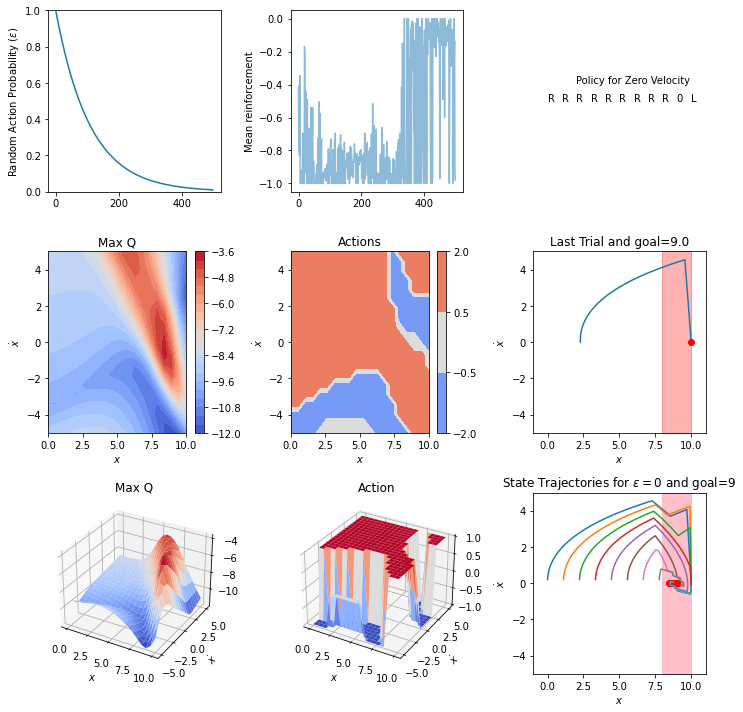

In [39]:
marble = Marble_Variable_Goal(valid_actions=np.array([-1, 0, 1]))

agent = Qnet(marble, hidden_layers=[10, 10],
             X_means=[5, 0, 5, 0], X_stds=[2, 2, 2, 0.8],
             Q_means=[-2], Q_stds=[1])

epsilon_trace, r_trace =  agent.train(n_trials=500, n_steps_per_trial=200, n_epochs=100,
                                      method='sgd', learning_rate=0.01, gamma=0.9,
                                      epsilon=1, final_epsilon=0.01,
                                      trial_callback=plot_status)

<font color='red'>Add some code</font> at the end of the notebook that applies the trained agent to the marble at goals from 1 to 9.  For each goal, start the marble at positions 0 through 10 with zero velocity and the specified goal and applies the trained agent to control the marble for 200 steps.  Calculate the distance of the final state from the goal.  Average this distance over all starting positions for the specified goal and store in a numpy array with one row for each goal and each row containing the goal and the average of distances to goal over all starting positions. Call this numpy array, `distances_to_goal`.  Plot the results of these average distances versus the goal.


In [40]:
def test_it_add_some_code(agent, n_trials, n_steps_per_trial):
    distances_to_goal = []
    distances_to_goal_temp = 0
    for test_goal in range(1,10):
        #xs = (0,1,2,3,4,5,6,7,8,9,10)
        xs = np.linspace(0, 10, n_trials)
    #For a number (n_trials) of starting positions, run marble sim for n_steps_per_trial
        for x in xs:
            s = [x, 0, test_goal]  # 0 initial_velocity
            x_trace = np.zeros((n_steps_per_trial, 3))
            for step in range(n_steps_per_trial):
                a = agent.epsilon_greedy(s, 0.0) # epsilon = 0
                s = agent.environment.next_state(s, a)
                x_trace[step, :] = s
            #print('x_trace',x_trace[-1][0])
            distances_to_goal_temp += (x_trace[-1][0] - test_goal) ##Calculate the distance of the final state from the goal.
        #print(distances_to_goal_temp/11)
        distances_to_goal.append(tuple((test_goal,distances_to_goal_temp/(len(xs))))) ## Average this distance over all starting positions for the specified goal 
        ## and store in a numpy array with one row for each goal 
        ## and each row containing the goal and the average of distances to goal over all starting positions.
        distances_to_goal_temp = 0 ## resetting temp variable
    return distances_to_goal

In [41]:
n_trials = 10
n_steps_per_trial = 200
distances_to_goal = test_it_add_some_code(agent, n_trials, n_steps_per_trial)
distances_to_goal

[(1, 1.3505260501032783),
 (2, 0.9889617089153429),
 (3, 0.7024249184653073),
 (4, 0.0004748082866590231),
 (5, 0.002016477965081531),
 (6, 0.08252786472386067),
 (7, 0.06552895105501984),
 (8, 0.0776566219896849),
 (9, -0.16591482887752934)]

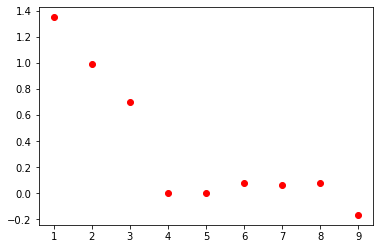

In [42]:
X = (list(list(zip(*distances_to_goal))[0]))
Y = (list(list(zip(*distances_to_goal))[1]))
plt.plot(X,Y,'ro')

In [43]:
m = np.std((list(list(zip(*distances_to_goal))[1])))
n = np.mean((list(list(zip(*distances_to_goal))[1])))
print(m,n)

0.5021464216420508 0.34491139695852285


#### Conclusion for the default case :
1.We can say that the distances_to_goal are fairly accurate, given that our reward criteria is set at less than '1'.

2.We get a mean of 0.345 and standard deviation of 0.502 .

3.That is all our final position values fall within the pink region (+- 0.5 units of goal value) in our plots for every starting point for every unique goal value.

4.The repeatability of results is an issue that I faced in this assignment.

5.Also replicability and reproducibilty of results is a isuue since we fail repeatability

### What I modified in the code:
1: The state array in Marble class now holds 3 elements, Xposition, Xvelocity, XVar_goal, added for the variable goal criteria.

2: Accordingly with the above addition we have to modify the following version of Class Marble --> Marble_Variable_Goal with changes done to the initial_state,next_state,reinforcement and plot_status function within this modified class.

3: In the above functions only the addition of the variable goal position has been done.

4: Changes have also been made to plot_status fucntion to accomodate for the variable pink region criteria in subplot 6 and 9 and the title change in subplot 9

### Experimentation

<font color='red'>Explore different parameter values</font>, including the network hidden layer structure, number of trials, number of steps per trial, learning rate, number of epochs, and final epsilon value to try to get the best results for `distances_to_goal`. Try just three or four different values for each parameter, varying one parameter value at a time. After you have found some parameter values that often work well, set the parameters to these values and run again to produce the graphs from `plot_status` showing the results with these parameters. But, first <font color='red'>modify `plot_status` code</font> for subplots 6 and 9 so that the vertical pink goal region correctly shows the current goal. Add the current goal to the title of the subplot 9.

#### 1. Varying Hidden layer Structure

###  1.1. Hidden_layers = [  ] : A linear model

In [70]:
marble = Marble_Variable_Goal(valid_actions=np.array([-1, 0, 1]))

agent = Qnet(marble, hidden_layers=[],
             X_means=[5, 0, 5, 0], X_stds=[2, 2, 2, 0.8],
             Q_means=[-2], Q_stds=[1])

epsilon_trace, r_trace =  agent.train(n_trials=500, n_steps_per_trial=200, n_epochs=100,
                                      method='sgd', learning_rate=0.01, gamma=0.9,
                                      epsilon=1, final_epsilon=0.01,
                                      trial_callback=False)

epsilon_decay is 0.9908319448927676


standard deviation and mean of distance_to_goal is = 2.581988897471611 5.0


[(1, 9.0),
 (2, 8.0),
 (3, 7.0),
 (4, 6.0),
 (5, 5.0),
 (6, 4.0),
 (7, 3.0),
 (8, 2.0),
 (9, 1.0)]

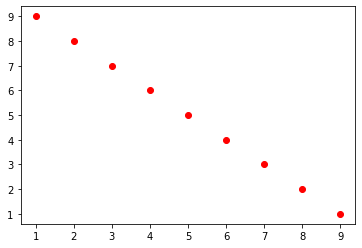

In [71]:
n_trials = 10
n_steps_per_trial = 200
distances_to_goal = test_it_add_some_code(agent, n_trials, n_steps_per_trial)
X = (list(list(zip(*distances_to_goal))[0]))
Y = (list(list(zip(*distances_to_goal))[1]))
plt.plot(X,Y,'ro')
m = np.std((list(list(zip(*distances_to_goal))[1])))
n = np.mean((list(list(zip(*distances_to_goal))[1])))
print('standard deviation and mean of distance_to_goal is =',m,n)
distances_to_goal

#### Conclusion : 
1: From the above plot it is clear that a linear model does not perform very well, with distance_to_goal being as high as 9 units.

### 1.2. Hidden_layers= [100] : Single hidden layer with 100 units

In [74]:
marble = Marble_Variable_Goal(valid_actions=np.array([-1, 0, 1]))

agent = Qnet(marble, hidden_layers=[100],
             X_means=[5, 0, 5, 0], X_stds=[2, 2, 2, 0.8],
             Q_means=[-2], Q_stds=[1])

epsilon_trace, r_trace =  agent.train(n_trials=500, n_steps_per_trial=200, n_epochs=100,
                                      method='sgd', learning_rate=0.01, gamma=0.9,
                                      epsilon=1, final_epsilon=0.01,
                                      trial_callback=False)

epsilon_decay is 0.9908319448927676


standard deviation and mean of distance_to_goal is = 1.998267507764918 2.5420424866341196


[(1, 5.887687710289887),
 (2, 5.268246958621272),
 (3, 4.050376041349274),
 (4, 2.9535783616889333),
 (5, 1.9829652754011282),
 (6, 1.2153364789983683),
 (7, 0.9584520492033398),
 (8, 0.45610319004919353),
 (9, 0.10563631410568117)]

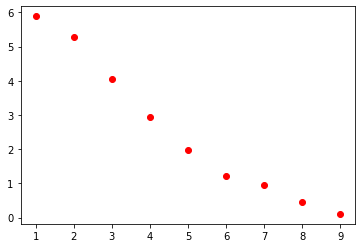

In [75]:
n_trials = 10
n_steps_per_trial = 200
distances_to_goal = test_it_add_some_code(agent, n_trials, n_steps_per_trial)
X = (list(list(zip(*distances_to_goal))[0]))
Y = (list(list(zip(*distances_to_goal))[1]))
plt.plot(X,Y,'ro')
m = np.std((list(list(zip(*distances_to_goal))[1])))
n = np.mean((list(list(zip(*distances_to_goal))[1])))
print('standard deviation and mean of distance_to_goal is =',m,n)
distances_to_goal

### Concluison : 
1: We can say that there is improvement when compared with a linear model, and the error or distances_to_goal does come down to near zero for some goal values.

### 1.3. Hidden_layers=[6,10,4] : 3 hidden layers with a total of 20 neurons.

In [63]:
marble = Marble_Variable_Goal(valid_actions=np.array([-1, 0, 1]))

agent = Qnet(marble, hidden_layers=[6,10,4],
             X_means=[5, 0, 5, 0], X_stds=[2, 2, 2, 0.8],
             Q_means=[-2], Q_stds=[1])

epsilon_trace, r_trace =  agent.train(n_trials=500, n_steps_per_trial=200, n_epochs=100,
                                      method='sgd', learning_rate=0.01, gamma=0.9,
                                      epsilon=1, final_epsilon=0.01,
                                      trial_callback=False)

epsilon_decay is 0.9908319448927676


standard deviation and mean of distance_to_goal is = 1.6605529898293951 -1.8504772671856928


[(1, -0.5461707451063319),
 (2, -0.41032276364022613),
 (3, -0.28091800566045955),
 (4, -0.6072238495690037),
 (5, -1.1026272592428978),
 (6, -1.8154058225970808),
 (7, -2.7640520928570096),
 (8, -3.8880517079234793),
 (9, -5.2395231580747454)]

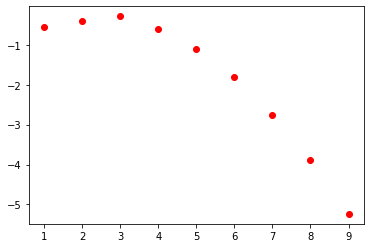

In [64]:
n_trials = 10
n_steps_per_trial = 200
distances_to_goal = test_it_add_some_code(agent, n_trials, n_steps_per_trial)
X = (list(list(zip(*distances_to_goal))[0]))
Y = (list(list(zip(*distances_to_goal))[1]))
plt.plot(X,Y,'ro')
m = np.std((list(list(zip(*distances_to_goal))[1])))
n = np.mean((list(list(zip(*distances_to_goal))[1])))
print('standard deviation and mean of distance_to_goal is =',m,n)
distances_to_goal

### Conclusion : 
1: From the above plot we can say that the error or distances to goal value has further improved, with a better mean value and standard deviation value.

### 1.4. Hidden_layers=[50,50] : A two hidden layer model with 50 units each.

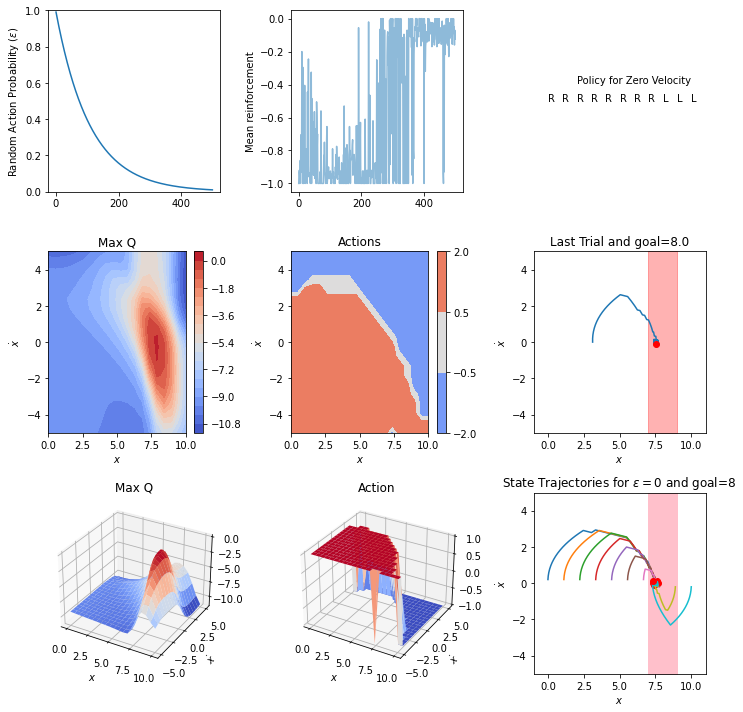

In [66]:
marble = Marble_Variable_Goal(valid_actions=np.array([-1, 0, 1]))

agent = Qnet(marble, hidden_layers=[50,50],
             X_means=[5, 0, 5, 0], X_stds=[2, 2, 2, 0.8],
             Q_means=[-2], Q_stds=[1])

epsilon_trace, r_trace =  agent.train(n_trials=500, n_steps_per_trial=200, n_epochs=100,
                                      method='sgd', learning_rate=0.01, gamma=0.9,
                                      epsilon=1, final_epsilon=0.01,
                                      trial_callback=plot_status)

standard deviation and mean of distance_to_goal is = 0.22640587990833058 -0.23932748284162944


[(1, 0.12050626182171856),
 (2, 0.045182637192982725),
 (3, -0.09397800711958833),
 (4, -0.16400152069563262),
 (5, -0.24569409821990035),
 (6, -0.331014217652324),
 (7, -0.38186127417043103),
 (8, -0.5375942879495529),
 (9, -0.5654928387819369)]

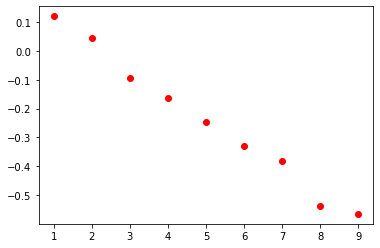

In [67]:
n_trials = 10
n_steps_per_trial = 200
distances_to_goal = test_it_add_some_code(agent, n_trials, n_steps_per_trial)
X = (list(list(zip(*distances_to_goal))[0]))
Y = (list(list(zip(*distances_to_goal))[1]))
plt.plot(X,Y,'ro')
m = np.std((list(list(zip(*distances_to_goal))[1])))
n = np.mean((list(list(zip(*distances_to_goal))[1])))
print('standard deviation and mean of distance_to_goal is =',m,n)
distances_to_goal

### Conclusion: 
1: This model gave good results with repeatibility, when compared with above models. 

2: With error values ranging in the + or - 0.5 units.

3: That is with all the goal values we reach the pink goal region from every starting position

4: From here onwards hidden layer model will be fixed to [ 50, 50 ]

### 2. Varying number of trials

### 2.1. n_trials=250

In [83]:
marble = Marble_Variable_Goal(valid_actions=np.array([-1, 0, 1]))

agent = Qnet(marble, hidden_layers=[50,50],
             X_means=[5, 0, 5, 0], X_stds=[2, 2, 2, 0.8],
             Q_means=[-2], Q_stds=[1])

epsilon_trace, r_trace =  agent.train(n_trials=250, n_steps_per_trial=200, n_epochs=100,
                                      method='sgd', learning_rate=0.01, gamma=0.9,
                                      epsilon=1, final_epsilon=0.01,
                                      trial_callback=False)

epsilon_decay is 0.9817479430199844


standard deviation and mean of distance_to_goal is = 3.528345415589179 -3.6882225082615445


[(1, 1.5986425644261946),
 (2, 0.7870083243511589),
 (3, -1.1710698127084636),
 (4, -2.4809544996334116),
 (5, -3.501539912455125),
 (6, -4.928907994330743),
 (7, -6.497181244003519),
 (8, -8.0),
 (9, -9.0)]

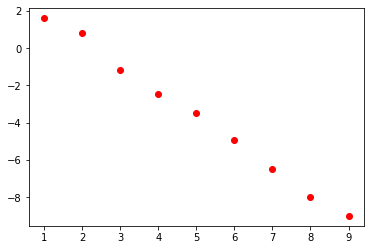

In [84]:
n_trials = 10
n_steps_per_trial = 200
distances_to_goal = test_it_add_some_code(agent, n_trials, n_steps_per_trial)
X = (list(list(zip(*distances_to_goal))[0]))
Y = (list(list(zip(*distances_to_goal))[1]))
plt.plot(X,Y,'ro')
m = np.std((list(list(zip(*distances_to_goal))[1])))
n = np.mean((list(list(zip(*distances_to_goal))[1])))
print('standard deviation and mean of distance_to_goal is =',m,n)
distances_to_goal

### Conclusion : 
1: A lower value of n_trails does not perform well, but it was expected

### 2.2. n_trials=750

In [101]:
marble = Marble_Variable_Goal(valid_actions=np.array([-1, 0, 1]))

agent = Qnet(marble, hidden_layers=[50,50],
             X_means=[5, 0, 5, 0], X_stds=[2, 2, 2, 0.8],
             Q_means=[-2], Q_stds=[1])

epsilon_trace, r_trace =  agent.train(n_trials=750, n_steps_per_trial=200, n_epochs=100,
                                      method='sgd', learning_rate=0.01, gamma=0.9,
                                      epsilon=1, final_epsilon=0.01,
                                      trial_callback=False)

epsilon_decay is 0.9938785857542514


standard deviation and mean of distance_to_goal is = 3.055910819436522 -3.004777398151468


[(1, -0.5464140739237907),
 (2, -0.6369192720912212),
 (3, -0.6977335402516751),
 (4, -1.2246429458173251),
 (5, -1.466595217826914),
 (6, -2.235569846038486),
 (7, -3.2351216874137974),
 (8, -8.0),
 (9, -9.0)]

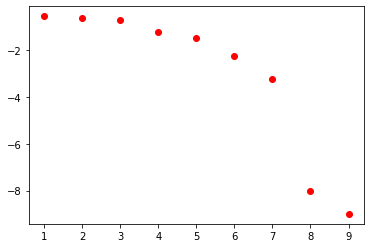

In [102]:
n_trials = 10
n_steps_per_trial = 200
distances_to_goal = test_it_add_some_code(agent, n_trials, n_steps_per_trial)
X = (list(list(zip(*distances_to_goal))[0]))
Y = (list(list(zip(*distances_to_goal))[1]))
plt.plot(X,Y,'ro')
m = np.std((list(list(zip(*distances_to_goal))[1])))
n = np.mean((list(list(zip(*distances_to_goal))[1])))
print('standard deviation and mean of distance_to_goal is =',m,n)
distances_to_goal

### Conlcusion:
1: This configuration with n_trails does not perform well when compared with n_trails = 500.

2: The error has a standard deviation of 3.05 and a mean of -3.005

### 2.2. n_trials=1000

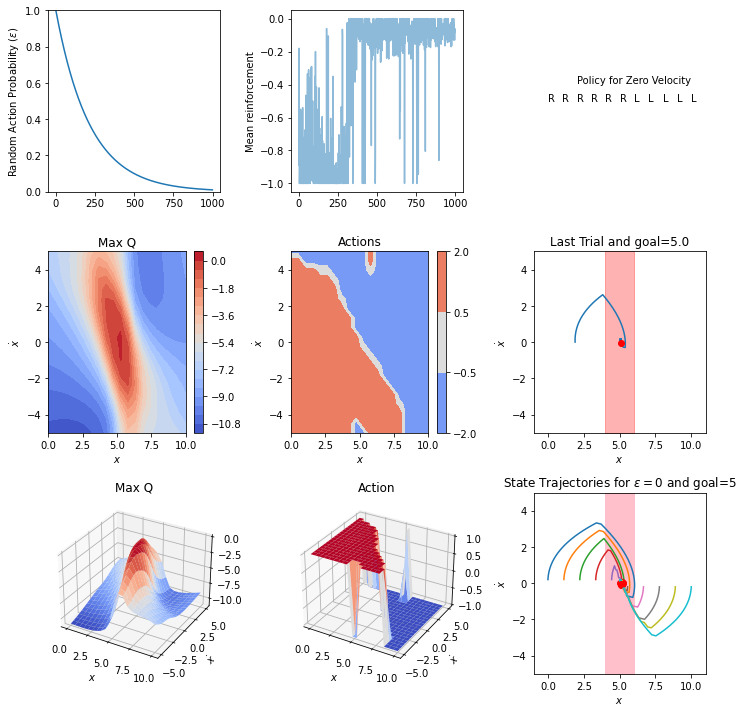

In [92]:
marble = Marble_Variable_Goal(valid_actions=np.array([-1, 0, 1]))

agent = Qnet(marble, hidden_layers=[50,50],
             X_means=[5, 0, 5, 0], X_stds=[2, 2, 2, 0.8],
             Q_means=[-2], Q_stds=[1])

epsilon_trace, r_trace =  agent.train(n_trials=1000, n_steps_per_trial=200, n_epochs=100,
                                      method='sgd', learning_rate=0.01, gamma=0.9,
                                      epsilon=1, final_epsilon=0.01,
                                      trial_callback=plot_status)

standard deviation and mean of distance_to_goal is = 0.13013936392889122 0.20999323893236543


[(1, 0.11634550377559114),
 (2, 0.13555933765303457),
 (3, 0.1295461425035514),
 (4, 0.1423476017894436),
 (5, 0.13276374332835114),
 (6, 0.1603129071175317),
 (7, 0.2125407752373553),
 (8, 0.3263553144154784),
 (9, 0.5341678245709515)]

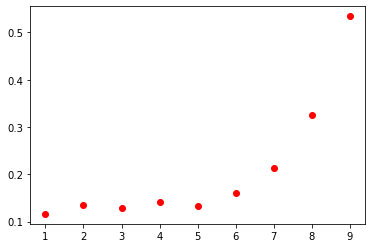

In [94]:
n_trials = 10
n_steps_per_trial = 200
distances_to_goal = test_it_add_some_code(agent, n_trials, n_steps_per_trial)
X = (list(list(zip(*distances_to_goal))[0]))
Y = (list(list(zip(*distances_to_goal))[1]))
plt.plot(X,Y,'ro')
m = np.std((list(list(zip(*distances_to_goal))[1])))
n = np.mean((list(list(zip(*distances_to_goal))[1])))
print('standard deviation and mean of distance_to_goal is =',m,n)
distances_to_goal

### Conclusion: 
1: There is significant increase in computational time and a significant decrease in mean and standard deviation of the distances_to_goal.

2: Going forward with n_trials = 1000

### 3. Varying Number of steps of trails

### 3.1. n_steps_per_trial=300

In [117]:
marble = Marble_Variable_Goal(valid_actions=np.array([-1, 0, 1]))

agent = Qnet(marble, hidden_layers=[50,50],
             X_means=[5, 0, 5, 0], X_stds=[2, 2, 2, 0.8],
             Q_means=[-2], Q_stds=[1])

epsilon_trace, r_trace =  agent.train(n_trials=1000, n_steps_per_trial=300, n_epochs=100,
                                      method='sgd', learning_rate=0.01, gamma=0.9,
                                      epsilon=1, final_epsilon=0.01,
                                      trial_callback=False)

epsilon_decay is 0.995405417351527


standard deviation and mean of distance_to_goal is = 0.12045621811487503 0.22978850198442047


[(1, 0.04850721417178967),
 (2, 0.12210877937187528),
 (3, 0.1699647522766084),
 (4, 0.1804597621065252),
 (5, 0.19991096697420102),
 (6, 0.23174522951121598),
 (7, 0.27047138714776986),
 (8, 0.3817345041494706),
 (9, 0.46319392215032806)]

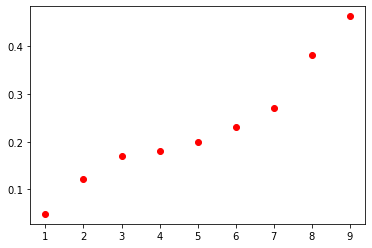

In [118]:
n_trials = 10
n_steps_per_trial = 200
distances_to_goal = test_it_add_some_code(agent, n_trials, n_steps_per_trial)
X = (list(list(zip(*distances_to_goal))[0]))
Y = (list(list(zip(*distances_to_goal))[1]))
plt.plot(X,Y,'ro')
m = np.std((list(list(zip(*distances_to_goal))[1])))
n = np.mean((list(list(zip(*distances_to_goal))[1])))
print('standard deviation and mean of distance_to_goal is =',m,n)
distances_to_goal

### Conclusion:
1: Increasing the value of n_steps_per_trial to 300, increases the computational time, without any effect on the performance of the RL agent.

### 3.2. n_steps_per_trial=50

In [120]:
marble = Marble_Variable_Goal(valid_actions=np.array([-1, 0, 1]))

agent = Qnet(marble, hidden_layers=[50,50],
             X_means=[5, 0, 5, 0], X_stds=[2, 2, 2, 0.8],
             Q_means=[-2], Q_stds=[1])

epsilon_trace, r_trace =  agent.train(n_trials=1000, n_steps_per_trial=50, n_epochs=100,
                                      method='sgd', learning_rate=0.01, gamma=0.9,
                                      epsilon=1, final_epsilon=0.01,
                                      trial_callback=False)

epsilon_decay is 0.995405417351527


standard deviation and mean of distance_to_goal is = 0.4282651321899597 0.12242906820722636


[(1, 1.2062450892931802),
 (2, 0.29573000235181157),
 (3, 0.29492712728535403),
 (4, -0.3150977639212318),
 (5, -0.19997418378370302),
 (6, -0.1027046789809459),
 (7, -0.07833768218388845),
 (8, -0.008729933400209777),
 (9, 0.009803637204670323)]

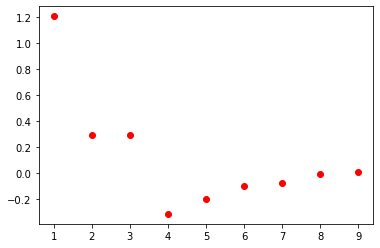

In [121]:
n_trials = 10
n_steps_per_trial = 200
distances_to_goal = test_it_add_some_code(agent, n_trials, n_steps_per_trial)
X = (list(list(zip(*distances_to_goal))[0]))
Y = (list(list(zip(*distances_to_goal))[1]))
plt.plot(X,Y,'ro')
m = np.std((list(list(zip(*distances_to_goal))[1])))
n = np.mean((list(list(zip(*distances_to_goal))[1])))
print('standard deviation and mean of distance_to_goal is =',m,n)
distances_to_goal

### Conclusion:
1: With reducing the n_steps_per_trial to 50, we get a reduced computation time but the standard deviation tells us that not all marbles reach their final goal value within +-0.5 units.

### 3.3. n_steps_per_trial=100

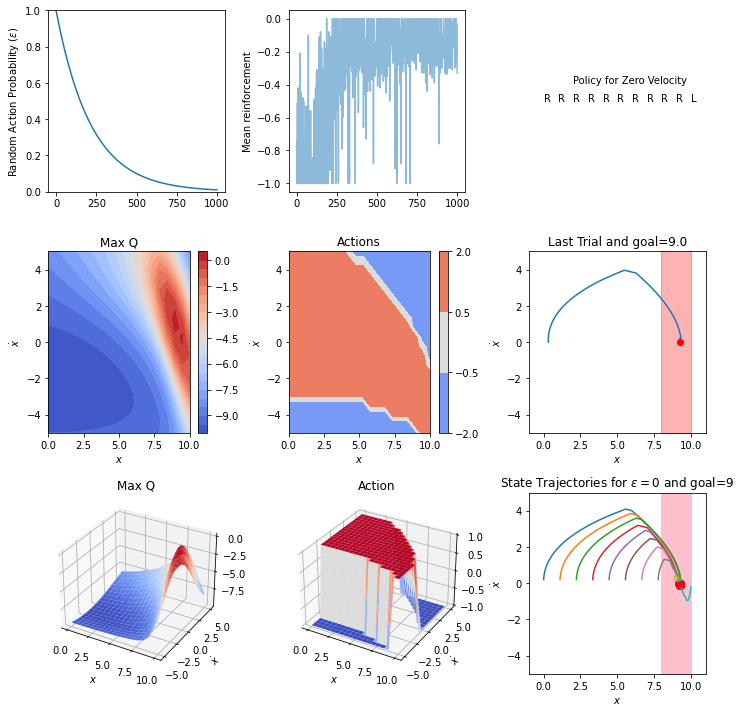

In [129]:
marble = Marble_Variable_Goal(valid_actions=np.array([-1, 0, 1]))

agent = Qnet(marble, hidden_layers=[50,50],
             X_means=[5, 0, 5, 0], X_stds=[2, 2, 2, 0.8],
             Q_means=[-2], Q_stds=[1])

epsilon_trace, r_trace =  agent.train(n_trials=1000, n_steps_per_trial=100, n_epochs=100,
                                      method='sgd', learning_rate=0.01, gamma=0.9,
                                      epsilon=1, final_epsilon=0.01,
                                      trial_callback=plot_status)

standard deviation and mean of distance_to_goal is = 0.2040995071991484 -0.04324465582081024


[(1, -0.42971747934491844),
 (2, -0.2982578037432351),
 (3, -0.1611979909391182),
 (4, -0.043016433113308494),
 (5, 0.004112591645217467),
 (6, 0.05261032309250382),
 (7, 0.10611446968233543),
 (8, 0.1454202255993568),
 (9, 0.2347301947338746)]

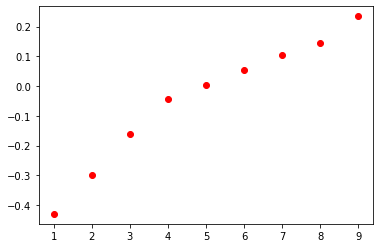

In [130]:
n_trials = 10
n_steps_per_trial = 200
distances_to_goal = test_it_add_some_code(agent, n_trials, n_steps_per_trial)
X = (list(list(zip(*distances_to_goal))[0]))
Y = (list(list(zip(*distances_to_goal))[1]))
plt.plot(X,Y,'ro')
m = np.std((list(list(zip(*distances_to_goal))[1])))
n = np.mean((list(list(zip(*distances_to_goal))[1])))
print('standard deviation and mean of distance_to_goal is =',m,n)
distances_to_goal

### Conclusion:
1: We can say that reducing the number of steps per trial does have a significant effect on the performance on the RL agent.

2: The error or distance_to_goal has a mean of -0.04 and a standard deviation of 0.20

3: A reduced value for number of steps per trials reduce computation time

4: Going forward we wil use n_steps_per_trial=100

### 4 Varying n_epochs

### 4.1 n_epochs = 50

In [131]:
marble = Marble_Variable_Goal(valid_actions=np.array([-1, 0, 1]))

agent = Qnet(marble, hidden_layers=[50,50],
             X_means=[5, 0, 5, 0], X_stds=[2, 2, 2, 0.8],
             Q_means=[-2], Q_stds=[1])

epsilon_trace, r_trace =  agent.train(n_trials=1000, n_steps_per_trial=100, n_epochs=50,
                                      method='sgd', learning_rate=0.01, gamma=0.9,
                                      epsilon=1, final_epsilon=0.01,
                                      trial_callback=False)

epsilon_decay is 0.995405417351527


standard deviation and mean of distance_to_goal is = 1.5037307476574089 1.4040065340459178


[(1, 4.1279079139930035),
 (2, 3.613215013068263),
 (3, 2.3687295119197223),
 (4, 1.3338998350588),
 (5, 0.5386350434481173),
 (6, 0.519034945337612),
 (7, 0.19150709013187228),
 (8, -0.09563927074731585),
 (9, 0.038768724203186264)]

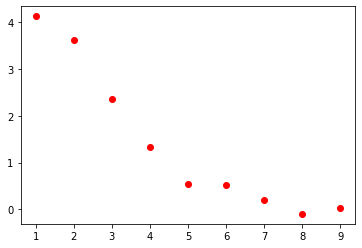

In [132]:
n_trials = 10
n_steps_per_trial = 200
distances_to_goal = test_it_add_some_code(agent, n_trials, n_steps_per_trial)
X = (list(list(zip(*distances_to_goal))[0]))
Y = (list(list(zip(*distances_to_goal))[1]))
plt.plot(X,Y,'ro')
m = np.std((list(list(zip(*distances_to_goal))[1])))
n = np.mean((list(list(zip(*distances_to_goal))[1])))
print('standard deviation and mean of distance_to_goal is =',m,n)
distances_to_goal

### Conclusion:
1: We can see that here error value or distances to goal values increases with decrease in number of epochs.

### 4.2 n_epochs = 150

In [133]:
marble = Marble_Variable_Goal(valid_actions=np.array([-1, 0, 1]))

agent = Qnet(marble, hidden_layers=[50,50],
             X_means=[5, 0, 5, 0], X_stds=[2, 2, 2, 0.8],
             Q_means=[-2], Q_stds=[1])

epsilon_trace, r_trace =  agent.train(n_trials=1000, n_steps_per_trial=100, n_epochs=150,
                                      method='sgd', learning_rate=0.01, gamma=0.9,
                                      epsilon=1, final_epsilon=0.01,
                                      trial_callback=False)

epsilon_decay is 0.995405417351527


standard deviation and mean of distance_to_goal is = 1.791471814510376 0.909586664980801


[(1, 4.109945545333315),
 (2, 2.8132667735531443),
 (3, 1.6997794545917853),
 (4, 1.420398265305416),
 (5, 1.1336755396585065),
 (6, 0.4418031258241476),
 (7, -0.446607598026089),
 (8, -1.0032669080177699),
 (9, -1.9827142133952471)]

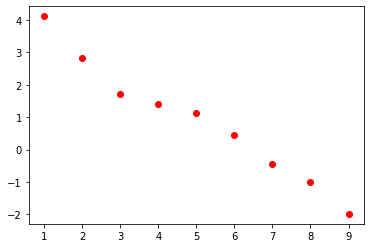

In [134]:
n_trials = 10
n_steps_per_trial = 200
distances_to_goal = test_it_add_some_code(agent, n_trials, n_steps_per_trial)
X = (list(list(zip(*distances_to_goal))[0]))
Y = (list(list(zip(*distances_to_goal))[1]))
plt.plot(X,Y,'ro')
m = np.std((list(list(zip(*distances_to_goal))[1])))
n = np.mean((list(list(zip(*distances_to_goal))[1])))
print('standard deviation and mean of distance_to_goal is =',m,n)
distances_to_goal

### Conclusion:
1: Here we can see that the error is better than before but still worse when number of epochs was set at 100.

### 4.3 n_epochs = 200

In [122]:
marble = Marble_Variable_Goal(valid_actions=np.array([-1, 0, 1]))

agent = Qnet(marble, hidden_layers=[50,50],
             X_means=[5, 0, 5, 0], X_stds=[2, 2, 2, 0.8],
             Q_means=[-2], Q_stds=[1])

epsilon_trace, r_trace =  agent.train(n_trials=1000, n_steps_per_trial=100, n_epochs=200,
                                      method='sgd', learning_rate=0.01, gamma=0.9,
                                      epsilon=1, final_epsilon=0.01,
                                      trial_callback=False)

epsilon_decay is 0.995405417351527


standard deviation and mean of distance_to_goal is = 0.34645493875927835 -0.2670457118161729


[(1, -0.028210183560473334),
 (2, -0.06783791468610148),
 (3, -0.09502147955559237),
 (4, -0.11106383942023501),
 (5, -0.10813565795508237),
 (6, -0.09127724363150565),
 (7, -0.07745085832957592),
 (8, -0.861854632375984),
 (9, -0.9625595968310066)]

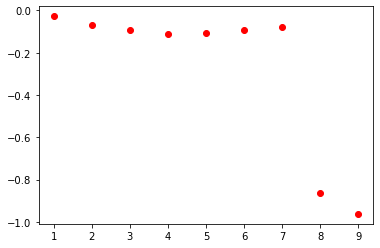

In [123]:
n_trials = 10
n_steps_per_trial = 200
distances_to_goal = test_it_add_some_code(agent, n_trials, n_steps_per_trial)
X = (list(list(zip(*distances_to_goal))[0]))
Y = (list(list(zip(*distances_to_goal))[1]))
plt.plot(X,Y,'ro')
m = np.std((list(list(zip(*distances_to_goal))[1])))
n = np.mean((list(list(zip(*distances_to_goal))[1])))
print('standard deviation and mean of distance_to_goal is =',m,n)
distances_to_goal

### Conclusion:
1: We can see that increasing number of number of epochs does decrease the error value but it is still below the error value when compared with n_epochs=100

2: So varying the number of epochs does not give any better results, so we'll keep the n_epochs at 100 from now on.

### 4.4 n_epochs = 100

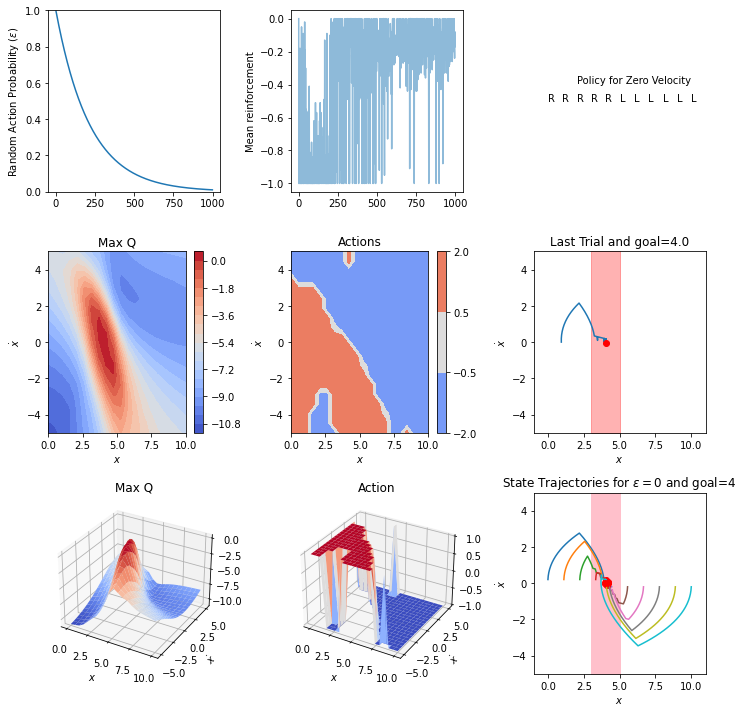

In [164]:
marble = Marble_Variable_Goal(valid_actions=np.array([-1, 0, 1]))

agent = Qnet(marble, hidden_layers=[50,50],
             X_means=[5, 0, 5, 0], X_stds=[2, 2, 2, 0.8],
             Q_means=[-2], Q_stds=[1])

epsilon_trace, r_trace =  agent.train(n_trials=1000, n_steps_per_trial=100, n_epochs=100,
                                      method='sgd', learning_rate=0.01, gamma=0.9,
                                      epsilon=1, final_epsilon=0.01,
                                      trial_callback=plot_status)

standard deviation and mean of distance_to_goal is = 0.4701254979743548 0.5056809696300024


[(1, 1.6441016219428957),
 (2, 0.7747559209899054),
 (3, 0.05780092911405155),
 (4, 0.10303371572967848),
 (5, 0.146975940185394),
 (6, 0.24084758622897962),
 (7, 0.35312401169046687),
 (8, 0.5379475964864657),
 (9, 0.6925414043021838)]

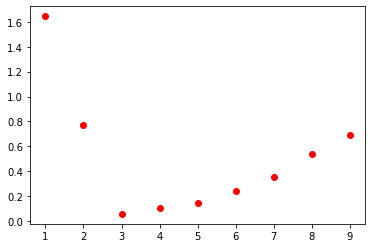

In [165]:
n_trials = 10
n_steps_per_trial = 200
distances_to_goal = test_it_add_some_code(agent, n_trials, n_steps_per_trial)
X = (list(list(zip(*distances_to_goal))[0]))
Y = (list(list(zip(*distances_to_goal))[1]))
plt.plot(X,Y,'ro')
m = np.std((list(list(zip(*distances_to_goal))[1])))
n = np.mean((list(list(zip(*distances_to_goal))[1])))
print('standard deviation and mean of distance_to_goal is =',m,n)
distances_to_goal

### Conclusion:
1: We can that with number of epochs at 100 the RL agents performance is as expected from our precious experiments, with exception of one outlier, that indicates the repeatibility issue.

## 5. Varying the Learning rate

### 5.1.  Learning rate = 0.001

In [139]:
marble = Marble_Variable_Goal(valid_actions=np.array([-1, 0, 1]))

agent = Qnet(marble, hidden_layers=[50,50],
             X_means=[5, 0, 5, 0], X_stds=[2, 2, 2, 0.8],
             Q_means=[-2], Q_stds=[1])

epsilon_trace, r_trace =  agent.train(n_trials=1000, n_steps_per_trial=100, n_epochs=100,
                                      method='sgd', learning_rate=0.001, gamma=0.9,
                                      epsilon=1, final_epsilon=0.01,
                                      trial_callback=False)

epsilon_decay is 0.995405417351527


standard deviation and mean of distance_to_goal is = 1.6345445840220518 -3.99235030600496


[(1, -1.0),
 (2, -2.0),
 (3, -3.0),
 (4, -4.0),
 (5, -4.3095272984878426),
 (6, -4.4147545740503045),
 (7, -5.196024170633896),
 (8, -5.61529347721479),
 (9, -6.395553233657808)]

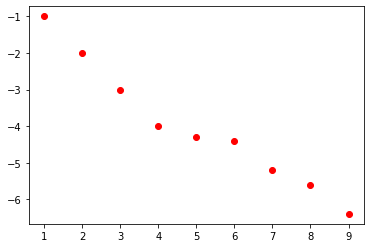

In [140]:
n_trials = 10
n_steps_per_trial = 200
distances_to_goal = test_it_add_some_code(agent, n_trials, n_steps_per_trial)
X = (list(list(zip(*distances_to_goal))[0]))
Y = (list(list(zip(*distances_to_goal))[1]))
plt.plot(X,Y,'ro')
m = np.std((list(list(zip(*distances_to_goal))[1])))
n = np.mean((list(list(zip(*distances_to_goal))[1])))
print('standard deviation and mean of distance_to_goal is =',m,n)
distances_to_goal

### Conclusion:
1: Reducing the learning rate increases the error, mean value and standard deviation value for distances_to_goal as can be seen from the above plot

### 5.2. Learning rate = 0.09

In [142]:
marble = Marble_Variable_Goal(valid_actions=np.array([-1, 0, 1]))

agent = Qnet(marble, hidden_layers=[50,50],
             X_means=[5, 0, 5, 0], X_stds=[2, 2, 2, 0.8],
             Q_means=[-2], Q_stds=[1])

epsilon_trace, r_trace =  agent.train(n_trials=1000, n_steps_per_trial=100, n_epochs=100,
                                      method='sgd', learning_rate=0.09, gamma=0.9,
                                      epsilon=1, final_epsilon=0.01,
                                      trial_callback=False)

epsilon_decay is 0.995405417351527


standard deviation and mean of distance_to_goal is = 2.4832878984291007 0.13785377770707985


[(1, 3.802005587867579),
 (2, 3.372823694739851),
 (3, 2.159940901484634),
 (4, 1.6049467230414343),
 (5, -1.1167516197196368),
 (6, -1.6871184960530357),
 (7, -1.906641085243045),
 (8, -1.3925214173612988),
 (9, -3.596000289392763)]

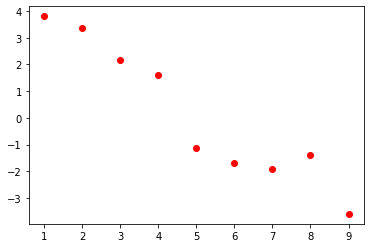

In [143]:
n_trials = 10
n_steps_per_trial = 200
distances_to_goal = test_it_add_some_code(agent, n_trials, n_steps_per_trial)
X = (list(list(zip(*distances_to_goal))[0]))
Y = (list(list(zip(*distances_to_goal))[1]))
plt.plot(X,Y,'ro')
m = np.std((list(list(zip(*distances_to_goal))[1])))
n = np.mean((list(list(zip(*distances_to_goal))[1])))
print('standard deviation and mean of distance_to_goal is =',m,n)
distances_to_goal

### Conclusion:
1: This model gives better results when compared wih the model above, but not as good as the default value for learning rate

### 5.3. Learning rate = 0.01

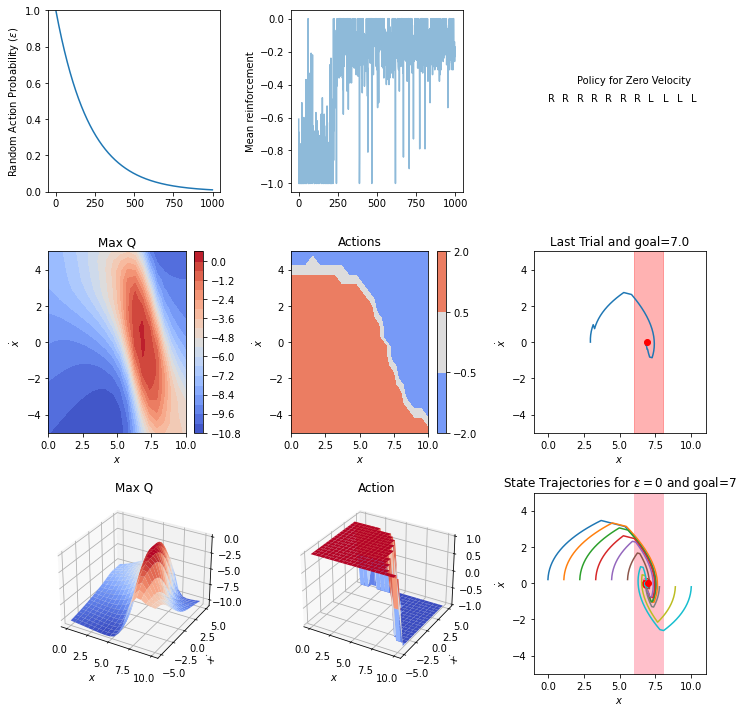

In [152]:
marble = Marble_Variable_Goal(valid_actions=np.array([-1, 0, 1]))

agent = Qnet(marble, hidden_layers=[50,50],
             X_means=[5, 0, 5, 0], X_stds=[2, 2, 2, 0.8],
             Q_means=[-2], Q_stds=[1])

epsilon_trace, r_trace =  agent.train(n_trials=1000, n_steps_per_trial=100, n_epochs=100,
                                      method='sgd', learning_rate=0.01, gamma=0.9,
                                      epsilon=1, final_epsilon=0.01,
                                      trial_callback=plot_status)

standard deviation and mean of distance_to_goal is = 0.10904714137910274 -0.2228014049953748


[(1, -0.4084485572989684),
 (2, -0.3441553505807743),
 (3, -0.30457998006006964),
 (4, -0.2482533176528349),
 (5, -0.22385896348329828),
 (6, -0.16557532727667706),
 (7, -0.14502827070108246),
 (8, -0.11338513147319702),
 (9, -0.05192774643147082)]

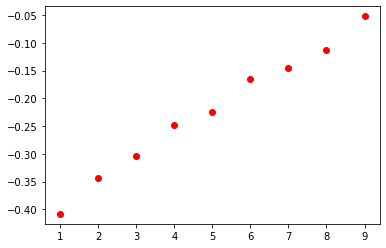

In [153]:
n_trials = 10
n_steps_per_trial = 200
distances_to_goal = test_it_add_some_code(agent, n_trials, n_steps_per_trial)
X = (list(list(zip(*distances_to_goal))[0]))
Y = (list(list(zip(*distances_to_goal))[1]))
plt.plot(X,Y,'ro')
m = np.std((list(list(zip(*distances_to_goal))[1])))
n = np.mean((list(list(zip(*distances_to_goal))[1])))
print('standard deviation and mean of distance_to_goal is =',m,n)
distances_to_goal

### Conclusion:
1: We can see that with a learning rate of 0.01 we get the best values.

2: A low mean value with a low standard deviation.

3: From here on learning rate will be 0.01

## 6. Varying Final Epsilon value

### 6.1. final_epsilon_value =0.001

In [155]:
marble = Marble_Variable_Goal(valid_actions=np.array([-1, 0, 1]))

agent = Qnet(marble, hidden_layers=[50,50],
             X_means=[5, 0, 5, 0], X_stds=[2, 2, 2, 0.8],
             Q_means=[-2], Q_stds=[1])

epsilon_trace, r_trace =  agent.train(n_trials=1000, n_steps_per_trial=100, n_epochs=100,
                                      method='sgd', learning_rate=0.01, gamma=0.9,
                                      epsilon=1, final_epsilon=0.001,
                                      trial_callback=False)

epsilon_decay is 0.9931160484209338


standard deviation and mean of distance_to_goal is = 0.2260697748024317 -0.4383797439674518


[(1, -0.5475081362947416),
 (2, -0.42468780473145584),
 (3, -0.45552159617552535),
 (4, -0.4059550210415862),
 (5, -0.3368615639618735),
 (6, -0.33945165812970207),
 (7, -0.22630480259873834),
 (8, -0.2006925374147232),
 (9, -1.0084345753587198)]

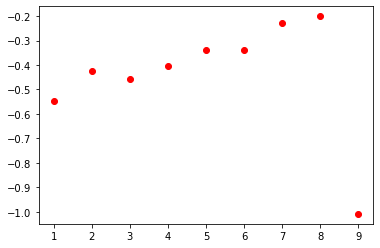

In [156]:
n_trials = 10
n_steps_per_trial = 200
distances_to_goal = test_it_add_some_code(agent, n_trials, n_steps_per_trial)
X = (list(list(zip(*distances_to_goal))[0]))
Y = (list(list(zip(*distances_to_goal))[1]))
plt.plot(X,Y,'ro')
m = np.std((list(list(zip(*distances_to_goal))[1])))
n = np.mean((list(list(zip(*distances_to_goal))[1])))
print('standard deviation and mean of distance_to_goal is =',m,n)
distances_to_goal

### Conclusion:
1: We can see that reducing final epsilon value does lead to a lower error value.

2: The mean and standard deviation tells us that the values lie within +-0.5 of the goal vlaue.

### 6.2. final_epsilon_value =0.0001

In [159]:
marble = Marble_Variable_Goal(valid_actions=np.array([-1, 0, 1]))

agent = Qnet(marble, hidden_layers=[50,50],
             X_means=[5, 0, 5, 0], X_stds=[2, 2, 2, 0.8],
             Q_means=[-2], Q_stds=[1])

epsilon_trace, r_trace =  agent.train(n_trials=1000, n_steps_per_trial=100, n_epochs=100,
                                      method='sgd', learning_rate=0.01, gamma=0.9,
                                      epsilon=1, final_epsilon=0.0001,
                                      trial_callback=False)

epsilon_decay is 0.9908319448927676


standard deviation and mean of distance_to_goal is = 0.8246087038975155 0.8746000797947642


[(1, 2.8523155470221586),
 (2, 1.745583986169501),
 (3, 0.9225207948960048),
 (4, 0.2660302451915792),
 (5, 0.3204341622916463),
 (6, 0.37775400742293963),
 (7, 0.3842020748758543),
 (8, 0.4565103594438389),
 (9, 0.5460495408393546)]

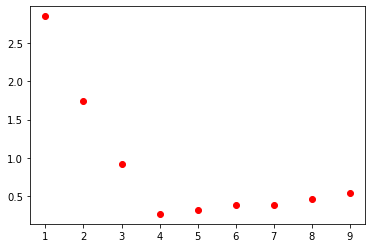

In [160]:
n_trials = 10
n_steps_per_trial = 200
distances_to_goal = test_it_add_some_code(agent, n_trials, n_steps_per_trial)
X = (list(list(zip(*distances_to_goal))[0]))
Y = (list(list(zip(*distances_to_goal))[1]))
plt.plot(X,Y,'ro')
m = np.std((list(list(zip(*distances_to_goal))[1])))
n = np.mean((list(list(zip(*distances_to_goal))[1])))
print('standard deviation and mean of distance_to_goal is =',m,n)
distances_to_goal

### Conclusion:
1: We can see that lowering the final epsilon value too much increases exploration but does not let the RL agent take optimal actions for which it is certain,that is it reduces exploitation.

### 6.3. final_epsilon_value =0.1

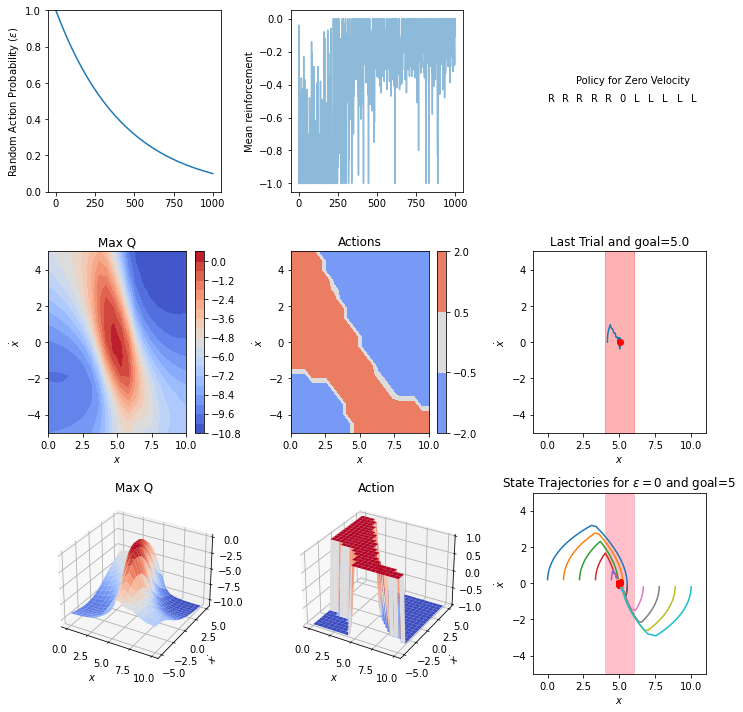

In [161]:
marble = Marble_Variable_Goal(valid_actions=np.array([-1, 0, 1]))

agent = Qnet(marble, hidden_layers=[50,50],
             X_means=[5, 0, 5, 0], X_stds=[2, 2, 2, 0.8],
             Q_means=[-2], Q_stds=[1])

epsilon_trace, r_trace =  agent.train(n_trials=1000, n_steps_per_trial=100, n_epochs=100,
                                      method='sgd', learning_rate=0.01, gamma=0.9,
                                      epsilon=1, final_epsilon=0.1,
                                      trial_callback=plot_status)

standard deviation and mean of distance_to_goal is = 0.24785713091656034 0.000280155799371092


[(1, -0.3848388319353651),
 (2, -0.2830909077718835),
 (3, -0.1810878188409438),
 (4, -0.08125229200829706),
 (5, -0.0014215206542750104),
 (6, 0.07299529980292166),
 (7, 0.1636244948359665),
 (8, 0.2786476870165856),
 (9, 0.4189452917496306)]

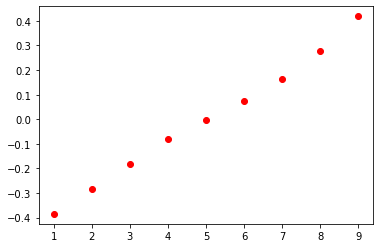

In [162]:
n_trials = 10
n_steps_per_trial = 200
distances_to_goal = test_it_add_some_code(agent, n_trials, n_steps_per_trial)
X = (list(list(zip(*distances_to_goal))[0]))
Y = (list(list(zip(*distances_to_goal))[1]))
plt.plot(X,Y,'ro')
m = np.std((list(list(zip(*distances_to_goal))[1])))
n = np.mean((list(list(zip(*distances_to_goal))[1])))
print('standard deviation and mean of distance_to_goal is =',m,n)
distances_to_goal

### Conclusion:
1: Here we get a lower error value or distnaces to goal for every possible goal and position value, when compared with the previous model.

2: This can be seen from the mean and standard deviation values.

# Discussion

1: From the above experiments we can say that the selection of the final epsilon value plays a vital role on the behavior of the RL agent and the accuracy which with it performs.

2: The structure of the neural net as we have seen plays a very significant role as a linear model was not able to get any of the distance_to_goal values to near zero.

3: The learning rate as expected a larger values has the tendency to hunt for the best value and not reach a minimum, on the other hand a lower value of learning rate causes the performance to be slow, so a tradeoff between computational time and a optimal learning rate needs to be figured.

4: A higher value for n_trails does increase the performance as it gives the RL agent enough trials to explore[given a good vaue for final_epsilon] and exploit the system, while increasing the computational time.

5: A lower value of number of steps per trials gives better results with increased number of trials.

6: Increasing the number of epochs does not have much effect of the performance of the RL agent.

# Grading

Download [A5grader.tar](https://www.cs.colostate.edu/~anderson/cs545/notebooks/A5grader.tar) and extract `A5grader.py` before running the following cell

In [80]:
%run -i A5grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Shetty-A5.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing:

    marble = Marble_Variable_Goal((-2, -1, 0, 1, 2))
    s = marble.initial_state()



---  20 / 20 points. initial_state correctly returns a state with 3 components.

Testing

    marble = Marble_Variable_Goal((-2, -1, 0, 1, 2))
    s = marble.initial_state()
    s = marble.next_state(s, 1)


---  20 / 20 points. next_state correctly returns a state with 3 components.

Testing

    marble = Marble_Variable_Goal((-2, -1, 0, 1, 2))
    s = []
    for i in range(10):
        s.append(marble.initial_state()[2])


    if len(np.unique(s)) > 1:
    np.random.seed(42)

    marble = Marble_Variable_Goal((-2, -1, 0, 1, 2))
    s = marble.initial_state()
    s = marble.next_state(s, 2)
    goal = s[2]
    s2 = marble.initial_state()
    goal2 = s2[2

<Figure size 432x288 with 0 Axes>

## Extra Credit

Receive 1 point of extra credit for each of these:

   * Modify your solution to this assignment by creating and using a `Marble2D` class that simulates the marble moving in two-dimensions, on a plane.  Some of the current plots will not work for this case. Just show the ones that are still appropriate.

In [68]:
class Agent2D(ABC):
    
    def __init__(self, environment):
        self.environment = environment

    @abstractmethod
    def make_samples(self, n_samples, epsilon):
        return X, R, Qn, terminal_state

    def update_Qn(self, X, Qn, terminal_state):
        n_samples = X.shape[0]
        for i in range(n_samples - 1):
            if not terminal_state[i+1]:
                Qn[i] = self.use(X[i+1])
        return Qn

    def epsilon_greedy(self, state, epsilon):
        valid_actions = self.environment.valid_actions
        action = [0,0]
        if np.random.uniform() < epsilon:
            action[0] = np.random.choice(valid_actions[0])
            action[1] = np.random.choice(valid_actions[1])
            # Random Move
        else:
            Qs = [self.use(np.hstack((state, valid_actions[0][ax],valid_actions[1][ay])).reshape((1, -1))) for ax in range(len(valid_actions[0])) for ay in range(len(valid_actions[1]))]
            aiX = np.argmax(Qs[0:3])
            aiY = np.argmax(Qs[4:7])
            action[0] = valid_actions[0][aiX]
            action[1] = valid_actions[1][aiX]

        return action

    @abstractmethod
    def train(self):
        return

    @abstractmethod
    def use(self, X):
        return # Q values for each row of X, each consisting of state and action

In [69]:
class Qnet2D(Agent2D): ## This is changed since Agent class is modified

    def __init__(self, environment, hidden_layers, X_means=None, X_stds=None, Q_means=None, Q_stds=None):
        self.environment = environment
        state_size = environment.initial_state().size  # assumes state is an np.array
        valid_actions = environment.valid_actions
        action_size = 1 if valid_actions.ndim == 1 else valid_actions.ndim ## This is change since shape[1] returns 3
        ## ---> below this line there are no changes

        self.Qnet = nn.NeuralNetwork(state_size + action_size, hidden_layers, 1)
        if X_means:
            self.Qnet.X_means = np.array(X_means)
            self.Qnet.X_stds = np.array(X_stds)
            self.Qnet.T_means = np.array(Q_means)
            self.Qnet.T_stds = np.array(Q_stds)

    def make_samples(self, n_samples, epsilon):
 
        state_size = self.environment.initial_state().size # assumes state is an np.array
        valid_actions = self.environment.valid_actions
        action_size = 1 if valid_actions.ndim == 1 else valid_actions.ndim
        #print(state_size,action_size)

        X = np.zeros((n_samples, state_size + action_size))
        #print(X.shape)
        R = np.zeros((n_samples, 1))
        Qn = np.zeros((n_samples, 1))
        terminal_state = np.zeros((n_samples, 1), dtype=bool)  # All False values

        state = self.environment.initial_state()
        action = [0,0]
        state = self.environment.next_state(state, action)        # Update state, sn from s and a
        action = self.epsilon_greedy(state, epsilon)

        # Collect data from n_samples steps
        for step in range(n_samples):

            next_state = self.environment.next_state(state, action)        # Update state, sn from s and a
            r = self.environment.reinforcement(state)   # Calculate resulting reinforcement
            next_action = self.epsilon_greedy(next_state, epsilon)
            X[step, :] = np.hstack((state, action))
            R[step, 0] = r
            if self.environment.terminal_state(state):
                terminal_state[step, 0] = True
                Qn[step, 0] = 0
            else:
                Qn[step, 0] = self.use(np.hstack((next_state, next_action)))
            # Advance one time step
            state, action = next_state, next_action

        return X, R, Qn, terminal_state

    #def update_Qn(self, X, Qn, terminal_state): ## defined twice can be removed
        #n_samples = X.shape[0]
        #for i in range(n_samples - 1):
         #   if not terminal_state[i+1]:
         #       Qn[i] = self.use(X[i+1])
        #return Qn

    def train(self, n_trials, n_steps_per_trial, n_epochs, method, learning_rate, 
              gamma, epsilon, final_epsilon,
              trial_callback=None):

        if trial_callback:
            fig = plt.figure(figsize=(10, 10))
            
        epsilon_decay =  np.exp(np.log(final_epsilon) / n_trials) # to produce this final value
        print('epsilon_decay is', epsilon_decay)
        epsilon_trace = np.zeros(n_trials)
        r_trace = np.zeros(n_trials)

        for trial in range(n_trials):

            X, R, Qn, terminal_state = self.make_samples(n_steps_per_trial, epsilon)

            for epoch in range(n_epochs):
                self.Qnet.train(X, R + gamma * Qn, 1,  method=method, learning_rate=learning_rate, batch_size=None, verbose=False)
                self.update_Qn(X, Qn, terminal_state)

            epsilon *= epsilon_decay

            # Rest is for plotting
            epsilon_trace[trial] = epsilon
            r_trace[trial] = np.mean(R)

            if trial_callback and (trial + 1 == n_trials or trial % (n_trials / 50) == 0):
                fig.clf()
                trial_callback(agent, trial, n_trials, X, epsilon_trace, r_trace)
                clear_output(wait=True)
                display(fig)

        if trial_callback:
            clear_output(wait=True)

        return epsilon_trace, r_trace

    def use(self, X):
        return self.Qnet.use(X)

In [70]:
class Marble_Variable_Goal_2D(Environment):

    def __init__(self, valid_actions):
        super().__init__(valid_actions)
        
    def initial_state(self):
        var_goalX = random.randint(1,9)
        var_goalY = random.randint(1,9)
        return np.array([10 * np.random.uniform(), 0.0, var_goalX, 10 * np.random.uniform(), 0.0, var_goalY])
        ##initial random position and initial velocity = 0  and desired goal position of the marble in a array
        
    def next_state(self, state, action):
        '''[0] is position, s[1] is velocity. a is -1, 0 or 1'''    
        next_state = state.copy()
        #print(next_state.shape)
        deltaT = 0.1                           # Euler integration time step
        next_state[0] += deltaT * state[1]                  # Update position
        next_state[3] += deltaT * state[4]
        #print(action)
        forceX = action[0]
        forceY = action[1]
        mass = 0.5
        next_state[1] += deltaT * (forceX / mass - 0.2 * state[1])  # Update velocity. Includes friction
        next_state[4] += deltaT * (forceY / mass - 0.2 * state[4])

        # Bound next position. If at limits, set velocity to 0.
        if next_state[0] and next_state[3] < 0:
            next_state = [0.,0.,next_state[2],0.,0.,next_state[5]]
        elif next_state[0] and next_state[3] > 10:
            next_state = [10.,0.,next_state[2],10.,0.,next_state[5]]
        elif next_state[0] < 0 and next_state[3] > 10:
            next_state = [0.,0.,next_state[2],10.,0.,next_state[5]]
        elif next_state[0] > 10 and next_state[3] < 0:
            next_state = [10.,0.,next_state[2],0.,0.,next_state[5]]
        elif next_state[0] < 0:        
            next_state = [0., 0., next_state[2],next_state[3], 0.,  next_state[5]]    # these constants as ints were causing the errors we discussed in class. I DON'T KNOW WHY!!
        elif next_state[0] > 10:
            next_state = [10., 0., next_state[2],next_state[3],0., next_state[5]]
        elif next_state[3] < 0:
            next_state = [next_state[0], 0.,next_state[2],0., 0., next_state[5]]
        elif next_state[3] > 10:
            next_state = [next_state[0], 0.,next_state[2],10., 0., next_state[5]]

        return next_state

    def reinforcement(self, state):
        goalX = state[2] # third element of the state array is the randomly generated desired goal value
        goalY = state[5]
        return 0 if abs(state[0] - goalX) and abs(state[3] - goalY) < 1 else -1

    def terminal_state(self, state):
        return False

## Run the below plot_status function for 2D marble demo and comment out the rest plot_status functions

In [79]:
# from matplotlib import cm

# def plot_status(agent, trial, n_trials, X, epsilon_trace, r_trace):
    

#     plt.subplot(3, 3, 1)
#     plt.plot(epsilon_trace[:trial + 1])
#     plt.ylabel('Random Action Probability ($\epsilon$)')
#     plt.ylim(0, 1)
               
#     plt.subplot(3, 3, 2)
#     plt.plot(r_trace[:trial + 1], alpha=0.5)
#     plt.ylabel('Mean reinforcement')
# #     print(X.shape)    
# #     valid_actions = agent.environment.valid_actions
# #     #print(np.array([[s, 0, var_goal, a] for a in valid_actions for s in range(11)]))
# #     qs = agent.use(np.array([[sx, 0, X[0,2], ax, sy, X[0,5], 0, ay] for ax in valid_actions for ay in valid_actions for sx in range(11) for sy in range(11)]))
# #     ##Above line for 2D and below line for 1D
# #     #qs = agent.use(np.array([[s, 0, X[0,2], a] for a in valid_actions for s in range(11)]))
               
# #     plt.subplot(3, 3, 3)
# #     acts = [['XL', 'X0', 'XR'],['YL', 'Y0', 'YR']]
# #     actsiByState = np.argmax(qs.reshape((len(valid_actions), -1)), axis=0)
# #     for j in range(11):
# #         for i in range(11):
# #             plt.text(i, 0, acts[actsiByState[i]])
# #     plt.xlim(-1, 11)
# #     plt.ylim(-1, 1)
# #     plt.text(2, 0.2,'Policy for Zero Velocity')
# #     plt.axis('off')
               
       
# #     plt.subplot(3, 3, 4)
# #     n = 20
# #     positions = np.linspace(0, 10, n)
# #     velocities =  np.linspace(-5, 5, n)
# #     xs, ys = np.meshgrid(positions, velocities)
# #     xsflat = xs.flat
# #     ysflat = ys.flat
# #     xs2, ys2 = np.meshgrid(positions, velocities)
# #     xsflat2 = xs2.flat
# #     ysflat2 = ys2.flat
# #     qs = agent.use(np.array([[xsflat1[i], ysflat1[i], X[0,2],xsflat2[i], ysflat2[i], X[0,5], a] for a in valid_actions for i in range(len(xsflat1))]))     
# #     qs = agent.use(np.array([[xsflat[i], ysflat[i], X[0,2], a] for a in valid_actions for i in range(len(xsflat))]))
# #     qs = qs.reshape((len(valid_actions), -1)).T
# #     qsmax = np.max(qs, axis=1).reshape(xs.shape)
# #     cs = plt.contourf(xs1, ys1, qsmax, 20, cmap=cm.coolwarm)
# #     plt.colorbar(cs)
# #     plt.xlabel('$x$')
# #     plt.ylabel('$\dot{x}$')
# #     plt.title('Max Q for X axis')

               
# #     plt.subplot(3, 3, 5)
# #     acts = np.array(valid_actions)[np.argmax(qs, axis=1)].reshape(xs.shape)
# #     cs = plt.contourf(xs, ys, acts, [-2, -0.5, 0.5, 2], cmap=cm.coolwarm)
# #     plt.colorbar(cs)
# #     plt.xlabel('$x$')
# #     plt.ylabel('$\dot{x}$')
# #     plt.title('Actions')

#     plt.subplot(3, 3, 6)
#     plt.plot(X[:, 0], X[: ,1])
#     plt.plot(X[-1, 0], X[-1, 1], 'ro')
#     plt.xlabel('$x$')
#     plt.ylabel('$\dot{x}$')
#     plt.fill_between([X[0,2]-1 , X[0,2]+1], [-5, -5], [5, 5], color='red', alpha=0.3)  # CHECK OUT THIS FUNCTION!
#     plt.xlim(-1, 11)
#     plt.ylim(-5, 5)
#     plt.title('Last Trial and goalX='+ str(X[0,2]))
    
#     plt.subplot(3, 3, 5)
#     plt.plot(X[:, 3], X[: ,4])
#     plt.plot(X[-1, 3], X[-1, 4], 'ro')
#     plt.xlabel('$y$')
#     plt.ylabel('$\dot{y}$')
#     plt.fill_between([X[0,5]-1 , X[0,5]+1], [-5, -5], [5, 5], color='red', alpha=0.3)  # CHECK OUT THIS FUNCTION!
#     plt.xlim(-1, 11)
#     plt.ylim(-5, 5)
#     plt.title('Last Trial and goalY='+ str(X[0,5]))
    
#     plt.subplot(3, 3, 7)
#     plt.plot(X[:, 0], X[: ,3])
#     plt.plot(X[-1, 0], X[-1, 3], 'ro')
#     plt.xlabel('$x$')
#     plt.ylabel('$y$')
#     plt.fill_between([X[0,2]-1 , X[0,2]+1], [X[0,5]-1], [X[0,5]+1], color='red', alpha=0.3)  # CHECK OUT THIS FUNCTION!
#     plt.xlim(-1, 11)
#     plt.ylim(-1, 11)
#     plt.title('Last Trial and goalXY='+ str(X[0,2]) + str(X[0,5]))

# #     ax = plt.subplot(3, 3, 7, projection='3d')
# #     ax.plot_surface(xs, ys, qsmax, linewidth=0, cmap=cm.coolwarm)
# #     ax.set_xlabel('$x$')
# #     ax.set_ylabel('$\dot{x}$')
# #     plt.title('Max Q')

# #     ax = plt.subplot(3, 3, 8, projection='3d')
# #     ax.plot_surface(xs, ys, acts, cmap=cm.coolwarm, linewidth=0)
# #     ax.set_xlabel('$x$')
# #     ax.set_ylabel('$\dot{x}$')
# #     plt.title('Action')
    
#     #test_it2D(agent, 10, 500)

#     plt.tight_layout()

# def test_it2D(agent, n_trials, n_steps_per_trial):
#     #for gl in range(10):
#     test_goalX = random.randint(1,9)
#     test_goalY = random.randint(1,9)
#     xs = np.linspace(0, 10, n_trials)
#     ys = np.linspace(0, 10, n_trials)
#     plt.subplot(3, 3, 9)
#     # For a number (n_trials) of starting positions, run marble sim for n_steps_per_trial
#     for y in ys:
#         for x in xs:
#             s = [x, 0, test_goalX, y, 0, test_goalY]  # 0 velocity
#             x_trace = np.zeros((n_steps_per_trial, 6))
#             for step in range(n_steps_per_trial):
#                 a = agent.epsilon_greedy(s, 0.0) # epsilon = 0
#                 s = agent.environment.next_state(s, a)
#                 x_trace[step, :] = s
            
#             plt.plot(x_trace[:, 0], x_trace[:, 1])
#             plt.plot(x_trace[:, 3], x_trace[:, 4])
#             plt.plot(x_trace[-1, 0], x_trace[-1, 1], 'ro')
#             plt.plot(x_trace[-1, 3], x_trace[-1, 4], 'ro')
#             plt.fill_between([test_goalX-1,test_goalX+1], [-5, -5], [5, 5], color='pink', alpha=0.3)
#             plt.xlim(-1, 11)
#             plt.ylim(-5, 5)
#             plt.ylabel('$\dot{x}$')
#             plt.xlabel('$x$')
#             plt.title('State Trajectories for $\epsilon=0$ and goal='+ str(test_goalX))


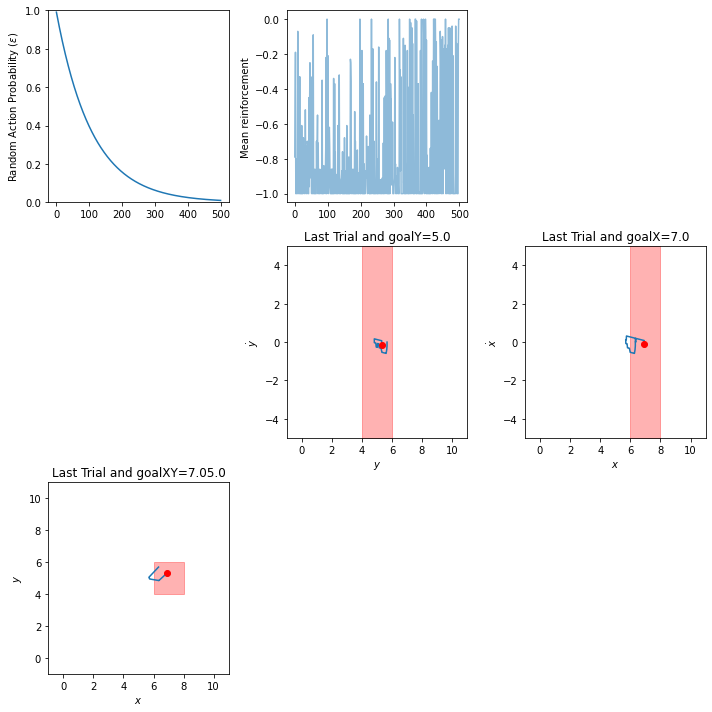

In [77]:
marble = Marble_Variable_Goal_2D(valid_actions=np.array([[-1, 0, 1],[-1, 0, 1]]))

agent = Qnet2D(marble, hidden_layers=[50, 50],
             X_means=[5, 0, 5, 5, 0, 5, 0, 0], X_stds=[2, 2, 2, 2, 2, 2,0.8,0.8],
             Q_means=[-2], Q_stds=[1])

epsilon_trace, r_trace =  agent.train(n_trials= 500, n_steps_per_trial=100, n_epochs=100,
                                      method='sgd', learning_rate=0.01, gamma=0.9,
                                      epsilon=1, final_epsilon=0.01,
                                      trial_callback=plot_status)

* Experiment with seven valid actions rather than three.  How does this change the behavior of the controlled marble?

##  Run the below plot_status function when running the 7 element action space and comment out the rest plot_status functions

In [65]:
# from matplotlib import cm

# def plot_status(agent, trial, n_trials, X, epsilon_trace, r_trace):
    

#     plt.subplot(3, 3, 1)
#     plt.plot(epsilon_trace[:trial + 1])
#     plt.ylabel('Random Action Probability ($\epsilon$)')
#     plt.ylim(0, 1)
               
#     plt.subplot(3, 3, 2)
#     plt.plot(r_trace[:trial + 1], alpha=0.5)
#     plt.ylabel('Mean reinforcement')
        
#     valid_actions = agent.environment.valid_actions
#     #print(np.array([[s, 0, var_goal, a] for a in valid_actions for s in range(11)]))
#     #qs = agent.use(np.array([[s, 0, X[0,2], s, X[0,5], 0, a] for a in valid_actions for s in range(11)]))
#     ##Above line for 2D and below line for 1D
#     qs = agent.use(np.array([[s, 0, X[0,2], a] for a in valid_actions for s in range(11)]))
               
#     plt.subplot(3, 3, 3)
#     acts = ['3L','2L','L', '0', 'R','2R','3R'] ## this is changed accomodate for 7 actions
#     actsiByState = np.argmax(qs.reshape((len(valid_actions), -1)), axis=0)
#     #print(actsiByState.shape)
#     for i in range(11):
#         plt.text(i, 0, acts[actsiByState[i]])
#         plt.xlim(-1, 11)
#         plt.ylim(-1, 1)
#     plt.text(2, 0.2,'Policy for Zero Velocity')
#     plt.axis('off')
               
       
#     plt.subplot(3, 3, 4)
#     n = 20
#     positions = np.linspace(0, 10, n)
#     velocities =  np.linspace(-5, 5, n)
#     xs, ys = np.meshgrid(positions, velocities)
#     xsflat = xs.flat
#     ysflat = ys.flat
#     qs = agent.use(np.array([[xsflat[i], ysflat[i], X[0,2], a] for a in valid_actions for i in range(len(xsflat))]))     
#     #qs = agent.use(np.array([[xsflat[i], ysflat[i], X[0,2], a] for a in valid_actions for i in range(len(xsflat))]))
#     qs = qs.reshape((len(valid_actions), -1)).T
#     qsmax = np.max(qs, axis=1).reshape(xs.shape)
#     cs = plt.contourf(xs, ys, qsmax, 20, cmap=cm.coolwarm)
#     plt.colorbar(cs)
#     plt.xlabel('$x$')
#     plt.ylabel('$\dot{x}$')
#     plt.title('Max Q')

               
#     plt.subplot(3, 3, 5)
#     acts = np.array(valid_actions)[np.argmax(qs, axis=1)].reshape(xs.shape)
#     cs = plt.contourf(xs, ys, acts, [-2, -0.5, 0.5, 2], cmap=cm.coolwarm)
#     plt.colorbar(cs)
#     plt.xlabel('$x$')
#     plt.ylabel('$\dot{x}$')
#     plt.title('Actions')

#     plt.subplot(3, 3, 6)
#     plt.plot(X[:, 0], X[: ,1])
#     plt.plot(X[-1, 0], X[-1, 1], 'ro')
#     plt.xlabel('$x$')
#     plt.ylabel('$\dot{x}$')
#     plt.fill_between([X[0,2]-1 , X[0,2]+1], [-6, -6], [6, 6], color='red', alpha=0.3)  # CHECK OUT THIS FUNCTION!
#     plt.xlim(-1, 11)
#     plt.ylim(-6, 6)
#     plt.title('Last Trial and goal='+ str(X[0,2]))

#     ax = plt.subplot(3, 3, 7, projection='3d')
#     ax.plot_surface(xs, ys, qsmax, linewidth=0, cmap=cm.coolwarm)
#     ax.set_xlabel('$x$')
#     ax.set_ylabel('$\dot{x}$')
#     plt.title('Max Q')

#     ax = plt.subplot(3, 3, 8, projection='3d')
#     ax.plot_surface(xs, ys, acts, cmap=cm.coolwarm, linewidth=0)
#     ax.set_xlabel('$x$')
#     ax.set_ylabel('$\dot{x}$')
#     plt.title('Action')
    
#     test_it(agent, 10, 500)

#     plt.tight_layout()

# def test_it(agent, n_trials, n_steps_per_trial):
#     #for gl in range(10):
#     test_goal = random.randint(1,9)
#     xs = np.linspace(0, 10, n_trials)
#     plt.subplot(3, 3, 9)
#     # For a number (n_trials) of starting positions, run marble sim for n_steps_per_trial
#     for x in xs:
#         s = [x, 0, test_goal]  # 0 velocity
#         x_trace = np.zeros((n_steps_per_trial, 3))
#         for step in range(n_steps_per_trial):
#             a = agent.epsilon_greedy(s, 0.0) # epsilon = 0
#             s = agent.environment.next_state(s, a)
#             x_trace[step, :] = s
            
#         plt.plot(x_trace[:, 0], x_trace[:, 1])
#         plt.plot(x_trace[-1, 0], x_trace[-1, 1], 'ro')
#         plt.fill_between([test_goal-1,test_goal+1], [-6, -6], [6, 6], color='pink', alpha=0.3)
#         plt.xlim(-1, 11)
#         plt.ylim(-6, 6)
#         plt.ylabel('$\dot{x}$')
#         plt.xlabel('$x$')
#         plt.title('State Trajectories for $\epsilon=0$ and goal='+ str(test_goal))


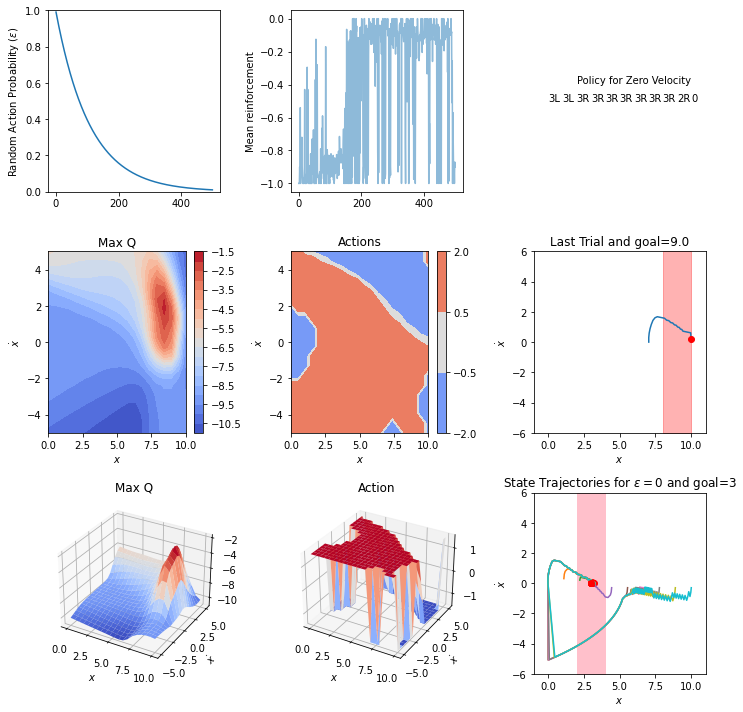

In [128]:
marble = Marble_Variable_Goal(valid_actions=np.array([-1.5, -1, -0.5, 0, 0.5, 1, 1.5]))

agent = Qnet(marble, hidden_layers=[10, 10],
             X_means=[5, 0, 5, 0], X_stds=[2, 2, 2, 0.8],
             Q_means=[-2], Q_stds=[1])

epsilon_trace, r_trace =  agent.train(n_trials=500, n_steps_per_trial=200, n_epochs=100,
                                      method='sgd', learning_rate=0.01, gamma=0.9,
                                      epsilon=1, final_epsilon=0.01,
                                      trial_callback=plot_status)

### Conclusion : 
1 : Convergence is achieved faster when compared with models with only 3 actions.

2 : We can see this in subplot 2 as we get rewards early at number of trials = 200

3 : We are incrementing with 0.5 units because the error margin is +- 0.5 units, which helps in giving a better result.